In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pygmsh
from scipy.interpolate import griddata

生成网格

In [2]:
with pygmsh.geo.Geometry() as geom:
    geom.add_polygon(
        [
            [0.0, 0.0],
            [1.0, 0.0],
            [1.0, 1.0],
            [0.0, 1.0],
        ],
        mesh_size=0.5,
    )
    mesh = geom.generate_mesh()

展示节点数据

In [3]:
mesh.point_data

{}

In [4]:
nodes=mesh.points
nodes

array([[0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.5       , 0.        , 0.        ],
       [1.        , 0.5       , 0.        ],
       [0.5       , 1.        , 0.        ],
       [0.        , 0.5       , 0.        ],
       [0.29375   , 0.70625   , 0.        ],
       [0.375     , 0.375     , 0.        ],
       [0.64791667, 0.64375   , 0.        ],
       [0.71875   , 0.28125   , 0.        ]])

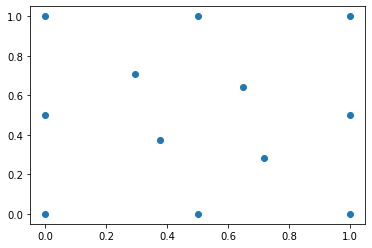

In [5]:
plt.scatter(mesh.points.T[0],mesh.points.T[1])

展示网格

In [6]:
mesh.get_cell_data

<bound method Mesh.get_cell_data of <meshio mesh object>
  Number of points: 12
  Number of cells:
    line: 8
    triangle: 14
    vertex: 4>

In [7]:
mesh.cells_dict['triangle']

array([[ 5,  2, 10],
       [ 7,  0,  9],
       [ 0,  4,  9],
       [ 2,  6, 10],
       [ 4,  1, 11],
       [ 1,  5, 11],
       [ 6,  3,  8],
       [ 3,  7,  8],
       [ 5, 10, 11],
       [ 8,  7,  9],
       [ 8,  9, 10],
       [ 9,  4, 11],
       [10,  9, 11],
       [ 6,  8, 10]], dtype=uint64)

In [8]:
elements=mesh.cells_dict['triangle']

In [9]:
E=10.0
nv=0.3
D=E/((1.0+nv)*(1.0-2*nv))*np.array([\
    [1.0-nv,nv,0.0], 
    [nv,1.0-nv,0.0], 
    [0.0,0.0,0.5-nv]])

In [10]:
len_global=2*len(nodes)

In [11]:
K=np.zeros((len_global,len_global))

In [12]:
for element in elements:
    x0=nodes[element[0]][0]
    y0=nodes[element[0]][1]
    x1=nodes[element[1]][0]
    y1=nodes[element[1]][1]
    x2=nodes[element[2]][0]
    y2=nodes[element[2]][1]
    area_2=np.linalg.det(np.array([\
        [1.0,x0,y0], 
        [1.0,x1,y1], 
        [1.0,x2,y2]]))
    B=1/area_2*np.array([\
        [y1-y2,0.0,y2-y0,0.0,y0-y1,0.0], 
        [0.0,x2-x1,0.0,x0-x2,0.0,x1-x0], 
        [x2-x1,y1-y2,x0-x2,y2-y0,x1-x0,y0-y1]])
    K_element=area_2*B.T@D@B
    deform_global_index=np.array([[2*element[i],2*element[i]+1] for i in range(3)],dtype=np.uint64).reshape(-1)
    for i_local,i_global in enumerate(deform_global_index):
        for j_local,j_global in enumerate(deform_global_index):
            K[i_global,j_global]+=K_element[i_local,j_local]

In [13]:
def get_position_local(element):
    x0=nodes[element[0]][0]
    y0=nodes[element[0]][1]
    x1=nodes[element[1]][0]
    y1=nodes[element[1]][1]
    x2=nodes[element[2]][0]
    y2=nodes[element[2]][1]
    return x0,y0,x1,y1,x2,y2

In [14]:
def det_B(x0,y0,x1,y1,x2,y2):
    matrix=np.array([\
        [1.0,x0,y0], 
        [1.0,x1,y1], 
        [1.0,x2,y2]])
    det=np.linalg.det(matrix)
    return abs(det)

In [15]:
def b_matrix(x0,y0,x1,y1,x2,y2,area_2):
    return 1/area_2*np.array([\
        [y1-y2,0.0,y2-y0,0.0,y0-y1,0.0], 
        [0.0,x2-x1,0.0,x0-x2,0.0,x1-x0], 
        [x2-x1,y1-y2,x0-x2,y2-y0,x1-x0,y0-y1]])

In [16]:
def element_integrate(B,D,area_2):
    return area_2*B.T@D@B

In [17]:
def Ke2K(element,K_element,K):
    deform_global_index=np.array([[2*element[i],2*element[i]+1] for i in range(3)],dtype=np.uint64).reshape(-1)
    for i_local,i_global in enumerate(deform_global_index):
        for j_local,j_global in enumerate(deform_global_index):
            K[i_global,j_global]+=K_element[i_local,j_local]

In [18]:
for element in elements:
    # calculate stiffness of element
    x0,y0,x1,y1,x2,y2=get_position_local(element)
    area_2=det_B(x0,y0,x1,y1,x2,y2)
    B=b_matrix(x0,y0,x1,y1,x2,y2,area_2)
    K_element=element_integrate(B,D,area_2)
    # add local Ke into global K
    Ke2K(element,K_element,K)

In [19]:
# interface
x_fix={}
y_fix={}
f_given={}
for index,position in enumerate(nodes):
    x=position[0].tolist()
    if x<1e-6:
        x_fix.update({index:0.0})
        y_fix.update({index:0.0})
    if 1.0-x<1e-6:
        f_given.update({index:(1.0,0.0)})

In [20]:
deform_free_index=[]
for node,_ in enumerate(nodes):
    if node not in x_fix:
        deform_free_index.append(2*node)
    if node not in y_fix:
        deform_free_index.append(2*node+1)
len_reduce=len(deform_free_index)

In [21]:
deform=np.zeros(len_global)
force=np.zeros(len_global)
for node in x_fix:
    deform[2*node]=x_fix[node]
for node in y_fix:
    deform[2*node+1]=y_fix[node]
for node in f_given:
    force[2*node]=f_given[node][0]
    force[2*node+1]=f_given[node][1]

In [22]:
deform_reduce=np.zeros(len_reduce)
force_reduce=np.zeros(len_reduce)

In [23]:
K_reduce=np.zeros((len_reduce,len_reduce))
for i_reduce,i_global in enumerate(deform_free_index):
    for j_reduce,j_global in enumerate(deform_free_index):
        K_reduce[i_reduce,j_reduce]=K[i_global,j_global]
for i_reduce,i_global in enumerate(deform_free_index):
    force_reduce[i_reduce]=force[i_global]

In [24]:
deform_reduce=np.linalg.solve(K_reduce,force_reduce)

In [25]:
for i_reduce,i_global in enumerate(deform_free_index):
    deform[i_global]=deform_reduce[i_reduce]

In [26]:
force=K@deform

In [27]:
deform_free_index

[2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23]

In [28]:
deform.reshape(len_global//2,2)

array([[ 0.        ,  0.        ],
       [ 0.07982204,  0.02095777],
       [ 0.0784962 , -0.02077183],
       [ 0.        ,  0.        ],
       [ 0.03425474,  0.0116895 ],
       [ 0.05178067, -0.00104916],
       [ 0.03587384, -0.01297189],
       [ 0.        ,  0.        ],
       [ 0.01532955, -0.00202707],
       [ 0.02033915,  0.00190167],
       [ 0.03608933, -0.00272211],
       [ 0.04310374,  0.00382737]])

In [29]:
def get_strain(deform_local):
    return B@deform_local
def get_stress(deform_local):
    return D@B@deform_local

In [30]:
def get_deform(element):
    n0=element[0].tolist()
    n1=element[1].tolist()
    n2=element[2].tolist()
    u0=deform[2*n0]
    v0=deform[2*n0+1]
    u1=deform[2*n1]
    v1=deform[2*n1+1]
    u2=deform[2*n2]
    v2=deform[2*n2+1]
    return u0,v0,u1,v1,u2,v2

In [31]:
def center_point(x0,y0,x1,y1,x2,y2):
    x=(x0+x1+x2)/3.0
    y=(y0+y1+y2)/3.0
    return [x,y]

In [32]:
show_data={'position':{'x':[],'y':[]},'strain':{'e11':[],'e22':[],'e12':[]},'stress':{'S11':[],'S22':[],'S12':[]}}
for element in elements:
    x0,y0,x1,y1,x2,y2=get_position_local(element)
    position_element=center_point(x0,y0,x1,y1,x2,y2)
    deform_local=get_deform(element)
    strain=get_strain(deform_local)
    stress=get_stress(deform_local)
    show_data['position']['x'].append(position_element[0])
    show_data['position']['y'].append(position_element[1])
    for i,name in enumerate(('e11','e22','e12')):
        show_data['strain'][name].append(strain[i])
    for i,name in enumerate(('S11','S22','S12')):
        show_data['stress'][name].append(stress[i])

C:\Users\MuTong\AppData\Local\Temp/ipykernel_7816/3417120346.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(grid_x,grid_y,z)


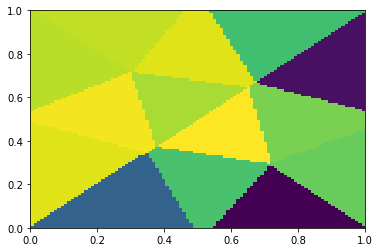

In [33]:
points=np.array([show_data['position']['x'],show_data['position']['y']]).T
values=show_data['stress']['S11']
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
z=griddata(points, values, (grid_x, grid_y), method='nearest')

fig, ax = plt.subplots()
ax.pcolormesh(grid_x,grid_y,z)